In [61]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlub-unsupervised-learning/y_train.p
/kaggle/input/mlub-unsupervised-learning/X_test.p
/kaggle/input/mlub-unsupervised-learning/X_unlabeled.p
/kaggle/input/mlub-unsupervised-learning/X_train.p


In [62]:
import pickle

In [63]:
X = pickle.load( open( "/kaggle/input/mlub-unsupervised-learning/X_train.p", "rb" ) )
y = pickle.load( open( "/kaggle/input/mlub-unsupervised-learning/y_train.p", "rb" ) )
X_unlabeled = pickle.load( open( "/kaggle/input/mlub-unsupervised-learning/X_unlabeled.p", "rb" ) )
X_test = pickle.load( open( "/kaggle/input/mlub-unsupervised-learning/X_test.p", "rb" ) )

[11]
(5000, 32, 32, 3)
uint8


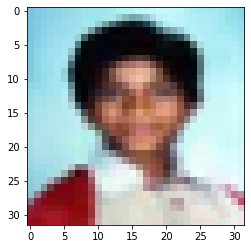

In [64]:
plt.imshow(X[3])
print(y[3])
print(X.shape)
print((X[3].dtype))

In [65]:
def show_reconstructions(model, images, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
def plot_image(image):
    plt.imshow(image)
    plt.axis("off")

In [66]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(X, y, test_size=0.20, random_state=66)

In [67]:
print(y_val.shape)
print(X_train.shape)

(1000, 1)
(4000, 32, 32, 3)


In [68]:
X_train = X_train.astype('float32') / 255.
X_val = X_val.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
X_unlabeled = X_unlabeled.astype('float32') / 255.

In [69]:
## With a Neural Network

import tensorflow as tf
from tensorflow import keras

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='selu', padding="SAME")

encoder = keras.models.Sequential([
    DefaultConv2D(filters=32, kernel_size=3, input_shape=[32, 32, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.2),
    DefaultConv2D(filters=32),
    keras.layers.Dropout(0.2),
    
])
encoder.summary()

decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, padding="SAME",activation="relu", input_shape=[4,4,32]),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2DTranspose(32, kernel_size=3, padding="SAME", activation="relu"),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2DTranspose(32, kernel_size=3, padding="SAME", activation="relu"),
    keras.layers.UpSampling2D((2,2)),
    keras.layers.Conv2DTranspose(32, kernel_size=3, padding="SAME", activation="relu"),
    keras.layers.Conv2DTranspose(3, kernel_size=3, padding="SAME", activation="sigmoid"),
])

#decoder.summary()
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          9

In [70]:
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_model.h5", save_best_only=True)
callbacks = [early_stopping_cb, model_checkpoint_cb]


auto = autoencoder.fit(X_unlabeled, X_unlabeled, epochs=100,
          validation_data=(X_val, X_val), callbacks=callbacks)



Epoch 1/100
1407/1407 [==============================] - 8s 5ms/step - loss: 0.0177 - accuracy: 0.6487 - val_loss: 0.0111 - val_accuracy: 0.7247
Epoch 2/100
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0129 - accuracy: 0.6961 - val_loss: 0.0101 - val_accuracy: 0.7514
Epoch 3/100
1407/1407 [==============================] - 8s 6ms/step - loss: 0.0120 - accuracy: 0.7033 - val_loss: 0.0094 - val_accuracy: 0.7428
Epoch 4/100
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0116 - accuracy: 0.7052 - val_loss: 0.0089 - val_accuracy: 0.7420
Epoch 5/100
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0113 - accuracy: 0.7071 - val_loss: 0.0086 - val_accuracy: 0.7487
Epoch 6/100
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0111 - accuracy: 0.7055 - val_loss: 0.0083 - val_accuracy: 0.7506
Epoch 7/100
1407/1407 [==============================] - 7s 5ms/step - loss: 0.0109 - accuracy: 0.7066 - val_loss: 0.0084 - val_ac

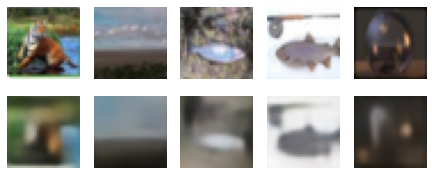

In [71]:
show_reconstructions(autoencoder, X_val, 5)

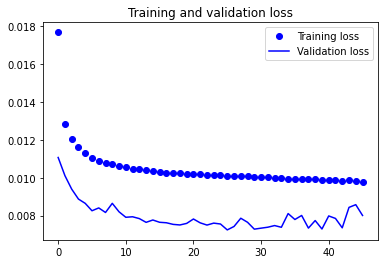

In [72]:
loss = np.array(auto.history['loss'])
val_loss = np.array(auto.history['val_loss'])
epochs = range(len(auto.history['accuracy']))
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Preparem el model per a la classificació

Per a aquest procés (classificació), de tot l'autoencoder només utilitzarem la part de l'encoder i a la sortida d'aquest hi afegirem capes fully connected per així obtenir la sortida de les 100 classes amb la funció d'activació Softmax i poder obtenir la classe amb la màxima resposta.

In [73]:
def fully_connected(ac):
    ac.add(keras.layers.Flatten())
    ac.add(keras.layers.Dense(units=256, activation='relu'))
    ac.add(keras.layers.Dropout(0.2))
    ac.add(keras.layers.Dense(units=128, activation='relu'))
    ac.add(keras.layers.Dropout(0.2))
    ac.add(keras.layers.Dense(units=128, activation='relu'))
    ac.add(keras.layers.Dropout(0.2))
    ac.add(keras.layers.Dense(100, activation='softmax'))
    return ac

full_model = fully_connected(encoder)

Fem un print dels pesos per a comprovar que estem utilitzant el model correctament.

In [74]:
print(autoencoder.get_weights()[0][1])
print("-----------------------------------")
print(full_model.get_weights()[0][1])

[[[ 7.58340359e-02  5.22414260e-02  6.61475286e-02  5.68470322e-02
    1.17118753e-01 -2.53725285e-03 -5.44266552e-02  6.08392432e-02
    7.02713476e-03 -4.78310660e-02  7.14463741e-02 -7.52503201e-02
    3.54756117e-02 -2.53204219e-02 -6.19911738e-02  5.31452373e-02
   -8.45715329e-02  1.01026762e-02  1.22524187e-04 -4.74100895e-02
   -9.41656008e-02  9.79602523e-03  3.90290469e-02  5.10091186e-02
   -1.02272563e-01  5.79307228e-02  3.29448618e-02  7.38895759e-02
   -7.15700863e-03 -2.88918894e-02 -1.69116333e-02  4.47861589e-02]
  [-9.28030908e-02  5.20612523e-02 -5.79277985e-02  1.73800383e-02
    4.57671285e-02  8.31600558e-03 -1.19807664e-02 -1.75103471e-02
   -2.71414630e-02  1.25029413e-02 -4.17689197e-02  2.88829263e-02
    1.43329212e-02  9.95982345e-03 -4.74615544e-02  1.86379720e-02
    5.73331453e-02  2.10747831e-02  1.00678462e-03  9.03994441e-02
    8.89869481e-02  5.02573401e-02 -1.44163845e-03 -1.59785971e-02
    4.72413888e-03 -4.16530780e-02 -8.09481665e-02 -7.2312243

Com que l'encoder ja ha sigut entrenat previament, posarem les capes corresponents a no entrenables mentre entrenem la nostra sortida.

In [75]:
for layer in full_model.layers[0:len(encoder.layers)]:
    layer.trainable = False
    
full_model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])


train = full_model.fit(X_train, y_train, epochs=100,
          validation_data=(X_val, y_val))


Epoch 1/100
125/125 [==============================] - 0s 4ms/step - loss: 4.6583 - accuracy: 0.0070 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6638 - accuracy: 0.0072 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6622 - accuracy: 0.0122 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6682 - accuracy: 0.0080 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 5/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6594 - accuracy: 0.0082 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6613 - accuracy: 0.0090 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 7/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6603 - accuracy: 0.0082 - val_loss: 4.6288 - val_accuracy: 0.0070

Epoch 58/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6651 - accuracy: 0.0090 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 59/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6648 - accuracy: 0.0103 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 60/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6610 - accuracy: 0.0098 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 61/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6598 - accuracy: 0.0090 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 62/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6687 - accuracy: 0.0098 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 63/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6624 - accuracy: 0.0113 - val_loss: 4.6288 - val_accuracy: 0.0070
Epoch 64/100
125/125 [==============================] - 0s 3ms/step - loss: 4.6626 - accuracy: 0.0093 - val_loss: 4.6288 - val_accuracy:

Seguidament, tornem a posar les capes a entrenables i entrenem el model sencer.

In [76]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 300:
        lr *= 0.5e-4
    elif epoch > 270:
        lr *= 1e-4
    elif epoch > 250:
        lr *= 0.1e-3
    elif epoch > 200:
        lr *= 0.25e-3
    elif epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [77]:
for layer in full_model.layers[0:len(encoder.layers)]:
    layer.trainable = True


full_model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

train = full_model.fit(X_train, y_train, epochs=300,
          validation_data=(X_val, y_val), callbacks = [lr_callback])

Learning rate:  0.001
Epoch 1/200
125/125 [==============================] - 1s 5ms/step - loss: 4.6011 - accuracy: 0.0182 - val_loss: 4.4974 - val_accuracy: 0.0350
Learning rate:  0.001
Epoch 2/200
125/125 [==============================] - 1s 4ms/step - loss: 4.4001 - accuracy: 0.0375 - val_loss: 4.2740 - val_accuracy: 0.0620
Learning rate:  0.001
Epoch 3/200
125/125 [==============================] - 0s 4ms/step - loss: 4.1628 - accuracy: 0.0645 - val_loss: 4.0126 - val_accuracy: 0.0930
Learning rate:  0.001
Epoch 4/200
125/125 [==============================] - 0s 4ms/step - loss: 3.9913 - accuracy: 0.0885 - val_loss: 3.9271 - val_accuracy: 0.0970
Learning rate:  0.001
Epoch 5/200
125/125 [==============================] - 0s 4ms/step - loss: 3.8613 - accuracy: 0.0935 - val_loss: 3.8628 - val_accuracy: 0.1250
Learning rate:  0.001
Epoch 6/200
125/125 [==============================] - 0s 4ms/step - loss: 3.7426 - accuracy: 0.1208 - val_loss: 3.8269 - val_accuracy: 0.1150
Learning r

125/125 [==============================] - 0s 4ms/step - loss: 2.0388 - accuracy: 0.4360 - val_loss: 3.9345 - val_accuracy: 0.1750
Learning rate:  0.001
Epoch 51/200
125/125 [==============================] - 0s 4ms/step - loss: 2.0193 - accuracy: 0.4467 - val_loss: 3.9199 - val_accuracy: 0.1970
Learning rate:  0.001
Epoch 52/200
125/125 [==============================] - 0s 4ms/step - loss: 2.0351 - accuracy: 0.4403 - val_loss: 3.9413 - val_accuracy: 0.1850
Learning rate:  0.001
Epoch 53/200
125/125 [==============================] - 0s 4ms/step - loss: 1.9594 - accuracy: 0.4627 - val_loss: 3.9845 - val_accuracy: 0.1900
Learning rate:  0.001
Epoch 54/200
125/125 [==============================] - 0s 4ms/step - loss: 1.9959 - accuracy: 0.4482 - val_loss: 3.8463 - val_accuracy: 0.1920
Learning rate:  0.001
Epoch 55/200
125/125 [==============================] - 0s 4ms/step - loss: 1.9818 - accuracy: 0.4538 - val_loss: 3.9406 - val_accuracy: 0.1900
Learning rate:  0.001
Epoch 56/200
125/

125/125 [==============================] - 0s 4ms/step - loss: 1.2835 - accuracy: 0.6233 - val_loss: 4.2922 - val_accuracy: 0.1820
Learning rate:  0.0001
Epoch 100/200
125/125 [==============================] - 0s 4ms/step - loss: 1.3139 - accuracy: 0.6240 - val_loss: 4.2526 - val_accuracy: 0.1750
Learning rate:  0.0001
Epoch 101/200
125/125 [==============================] - 0s 4ms/step - loss: 1.2561 - accuracy: 0.6345 - val_loss: 4.2884 - val_accuracy: 0.1870
Learning rate:  0.0001
Epoch 102/200
125/125 [==============================] - 0s 4ms/step - loss: 1.2968 - accuracy: 0.6145 - val_loss: 4.2589 - val_accuracy: 0.1870
Learning rate:  0.0001
Epoch 103/200
125/125 [==============================] - 1s 6ms/step - loss: 1.2453 - accuracy: 0.6332 - val_loss: 4.2805 - val_accuracy: 0.1820
Learning rate:  0.0001
Epoch 104/200
125/125 [==============================] - 1s 4ms/step - loss: 1.2784 - accuracy: 0.6230 - val_loss: 4.2718 - val_accuracy: 0.1890
Learning rate:  0.0001
Epoch 

125/125 [==============================] - 1s 5ms/step - loss: 1.1599 - accuracy: 0.6550 - val_loss: 4.3528 - val_accuracy: 0.1850
Learning rate:  1e-05
Epoch 149/200
125/125 [==============================] - 1s 4ms/step - loss: 1.1839 - accuracy: 0.6503 - val_loss: 4.3510 - val_accuracy: 0.1830
Learning rate:  1e-05
Epoch 150/200
125/125 [==============================] - 0s 4ms/step - loss: 1.1713 - accuracy: 0.6525 - val_loss: 4.3529 - val_accuracy: 0.1800
Learning rate:  1e-05
Epoch 151/200
125/125 [==============================] - 0s 4ms/step - loss: 1.1639 - accuracy: 0.6522 - val_loss: 4.3546 - val_accuracy: 0.1760
Learning rate:  1e-05
Epoch 152/200
125/125 [==============================] - 0s 4ms/step - loss: 1.1902 - accuracy: 0.6522 - val_loss: 4.3547 - val_accuracy: 0.1800
Learning rate:  1e-05
Epoch 153/200
125/125 [==============================] - 0s 4ms/step - loss: 1.1360 - accuracy: 0.6637 - val_loss: 4.3544 - val_accuracy: 0.1810
Learning rate:  1e-05
Epoch 154/20

125/125 [==============================] - 0s 4ms/step - loss: 1.2019 - accuracy: 0.6453 - val_loss: 4.3606 - val_accuracy: 0.1760
Learning rate:  5e-07
Epoch 198/200
125/125 [==============================] - 0s 4ms/step - loss: 1.1552 - accuracy: 0.6610 - val_loss: 4.3605 - val_accuracy: 0.1760
Learning rate:  5e-07
Epoch 199/200
125/125 [==============================] - 0s 4ms/step - loss: 1.1666 - accuracy: 0.6670 - val_loss: 4.3601 - val_accuracy: 0.1760
Learning rate:  5e-07
Epoch 200/200
125/125 [==============================] - 1s 4ms/step - loss: 1.2163 - accuracy: 0.6365 - val_loss: 4.3595 - val_accuracy: 0.1760


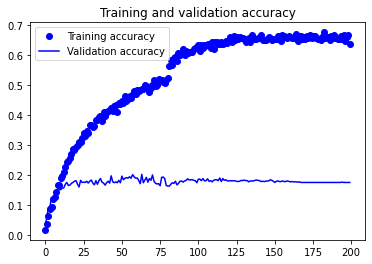

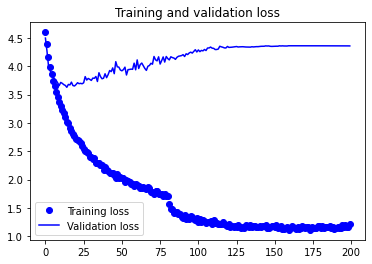

In [78]:
accuracy = train.history['accuracy']
val_accuracy = train.history['val_accuracy']
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [79]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred_val = full_model.predict(X_val)
yhat = [np.argmax(y) for y in y_pred_val]
acc = accuracy_score(y_val, yhat)
acc

0.176

In [80]:
y_pred = full_model.predict(X_test)
y_pred = [np.argmax(y) for y in y_pred ]
df = pd.DataFrame(y_pred)
df.columns =['label']
df.index.name = 'index'
df.to_csv('y_output.csv')

### El Model

- Autoencoder

Aquest consta de dues parts: l'encoder i el decoder.

A la part de l'encoder he sigut curós de tal manera que a la sortida tinguessim una representació suficientment petita per a que el nostre model pugués generalitzar correctament (4x4x32).
Al decoder m'he limitat a fer el camí invers per a reconstruir l'imatge a partir de la codificació de l'encoder.

Posem a entrenar l'autoencoder amb el set d'imatges no etiquetades i les imatges resultants són una representació sorollosa de la imatge original, però es pot apreciar bastant bé de quin objecte es tracta.

- Encoder + Fully connected (Classificació)

Per a classificar les imatges només farem us de la part de l'encoder del nostre autoencoder.

Per a poder fer la tasca de classificació fem una funció que ens permeti afegir capes fully connected a la part de l'encoder. 
Un cop afegides, com que la part de l'encoder ja ha estat previament entrenada, posem les capes corresponents (a l'encoder) a no entrenables i  només entrenem les capes Dense del nostre nou model. L'última de les capes serà una capa densa amb una activació softmax amb una sortida de 100, ja que, tenim 100 classes a predir.

Seguidament, posem totes les capes del nostre model com a entrenables i entrenem el model sencer per a un millor rendiment.

- Observacions per augmentar el rendiment

Per a millorar l'aprenentatge del nostre model, hem anat canviant el learning rate. Com ja he mencionat al projecte 5, el learning rate és la quantitat de pesos que s'actualitzen a la xarxa mentres dura l'entrenament. Es considera una bona pràctica fer decaure aquest hiperparàmetre a mesura que avancen les epochs. 

Ajustar aquest aspecte ajuda al model a que entreni de forma òptima.

També he fet ús del early stop que ens proporciona keras, aquest ens permet para el model quan ja no està entrenant. Això ens permet estalviar-nos temps de computació.

- Conclusions finals

En aquest projecte s'ha pogut demostrar la superioritat de les CNN envers de les NN en l'àmbit de la classificació i tractament d'imatges. 

Si parlem del rendiment del nostre autoencoder, considero que compleix els requeriments. Partim d'una imatge de 32x32x3 i l'encoder la redueix a 4x4x32, una dimensió suficient per a que el decoder faci el camí invers i puguem distingir de que es tracta la imatge i que en el model de classificació pugui generalitzar bé.
El fet d'entrenar les capes Dense a part em dóna un plus en el rendiment del model i ho acaba de millorar el fet d'entrenar-ho tot junt (encoder + FC).
